## Original

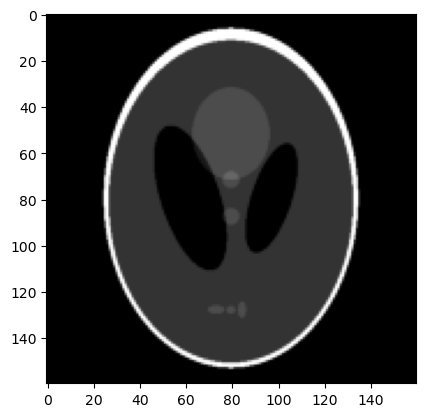

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage import color, io, util, transform
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

import matplotlib as mpl
mpl.rc('image', cmap='gray') #para no tener que pasar cmap='gray' cada vez que ploteo algo

#input = io.imread('gabu.jpg')
#image = util.img_as_float32(transform.resize(input, (257, 257), anti_aliasing=True))
#assert len(image.shape) == 2 and image.shape[0] == image.shape[1]
#image = image[...,0]

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

N = image.shape[0]

plt.figure()
plt.imshow(image)


## Sinograma

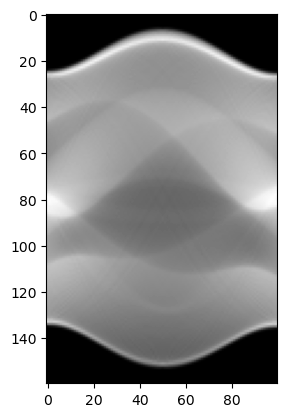

In [43]:
max_angle = 180.0
P = 100 # cant proyecciones, no necesariamente igual a N
#angles = np.linspace(0.0, max_angle, N)
angles = np.arange(0, 180, 180/P)
sinogram = transform.radon(image, theta=angles)

plt.figure()
plt.imshow(sinogram)

## reconstrucción con Python

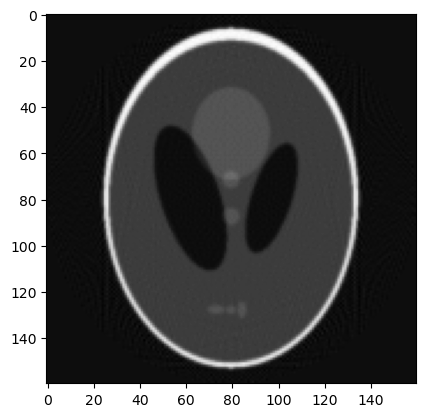

In [3]:
#num_projection = N*len(angles)
r1 = transform.iradon(sinogram, theta=angles) #filter_name = alguno entre ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
plt.figure()
plt.imshow(r1)

## reconstrucción ART

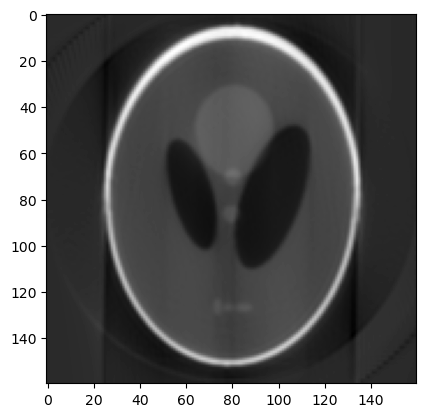

In [29]:
ir = np.zeros((N, N))
tdiff = np.zeros((N, N))
step = angles[1] - angles[0]
#L = len(ir)

niter = 1
for i in range(niter):
    for j in range(len(angles)):
        ir = transform.rotate(ir, step, order=5)
        tmp = sinogram[:,j] * N
        temp = np.sum(ir, axis=0)
        diff = (tmp - temp) / N
        
        for k in range(N):
            tdiff[k] = diff

        ir = ir + tdiff

plt.figure()
plt.imshow(ir)

## reconstrucción FBP V1

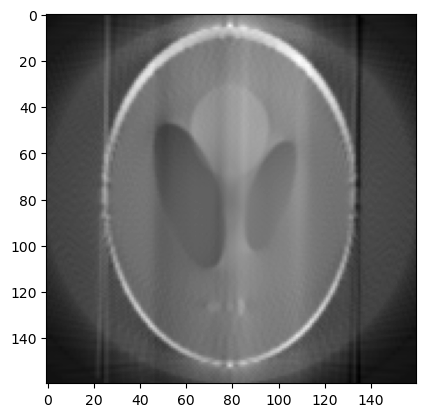

In [12]:
from scipy import fft

bp = np.zeros((N,N))
tmp = bp.copy()

ramlak = abs(np.linspace(-1,1,P).T)
#ramlak = np.ones(N).T


fft_R = fft.fftshift(fft.fft(sinogram))
filtproj = fft.ifftshift(fft_R * ramlak)
sg = np.real(fft.ifft(filtproj))

for i in range(P):
    tmp = np.tile(sg[:,i].T, (N, 1))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

plt.figure()
plt.imshow(bp)


## Reconstrucción FBP V2

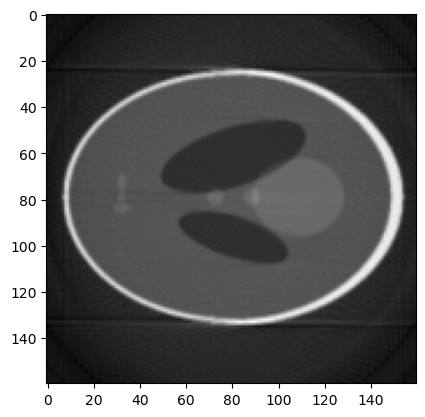

In [38]:
from scipy.fft import fft, fftshift, ifft, ifftshift

sg = sinogram.copy()
bp = np.zeros((N,N))
tmp = bp.copy()

ramlak = abs(np.linspace(-1,1,N))

#sinog = sinogram.copy()
sinog = np.swapaxes(sinogram, 0, 1)
fft_R = fftshift(fft(sinog))
filtproj = ifftshift(fft_R * ramlak)
sg = np.real(ifft(filtproj))

sg = np.swapaxes(sg, 0, 1)


for i in range(P):
    tmp = np.repeat(sg[:,i], N).reshape((N,N))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

plt.figure()
plt.imshow(bp)


## Ventanas

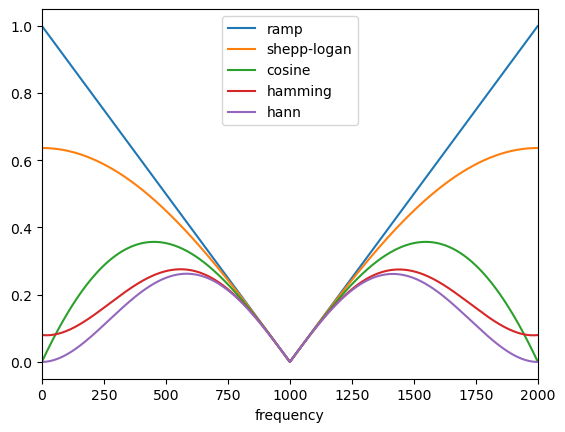

In [14]:
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(fftshift(response), label=f)

plt.xlim([0, 2000])
plt.xlabel('frequency')
plt.legend()
plt.show()


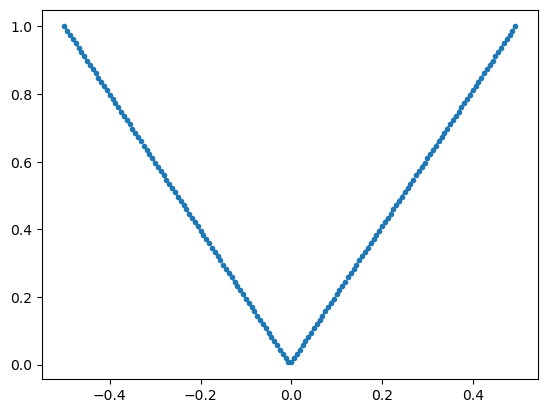

In [15]:
from scipy.fft import fftfreq

ramlak = abs(np.linspace(-1,1,len(sg)))
freqs = fftshift(fftfreq(len(ramlak)))

plt.plot(freqs, ramlak, '.--')
plt.show()

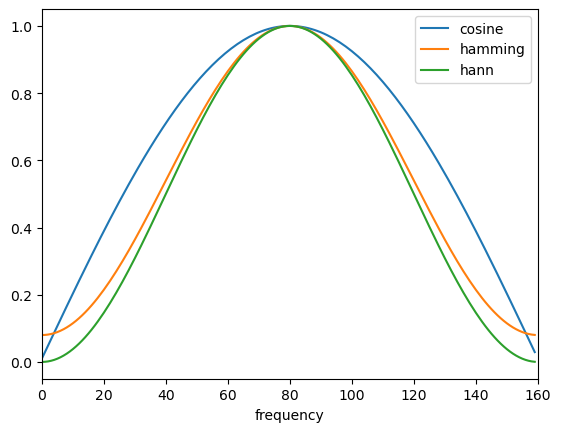

In [16]:
from scipy.signal import get_window

windows = ['cosine', 'hamming', 'hann']

for ix, f in enumerate(windows):
    response = get_window(f, len(ramlak))
    plt.plot(response, label=f)

plt.xlim([0, len(ramlak)])
plt.xlabel('frequency')
plt.legend()
plt.show()

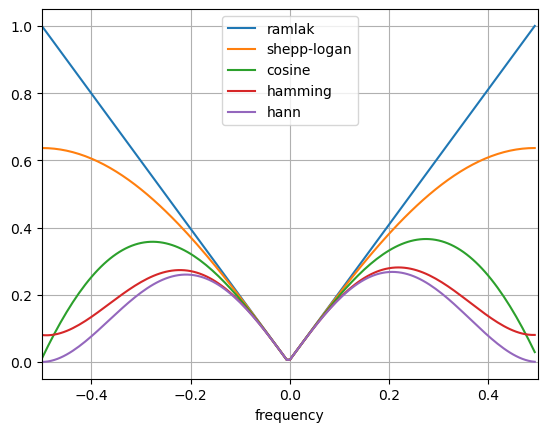

In [17]:
windows = ['cosine', 'hamming', 'hann']

plt.plot(freqs, ramlak, label='ramlak')

responses = {}

responses['ramlak'] = ramlak

sheppLogan = ramlak * np.sinc(ramlak/2)

plt.plot(freqs, sheppLogan, label='shepp-logan')

responses['shepp-logan'] = sheppLogan

for ix, f in enumerate(windows):
    response = get_window(f, len(ramlak))
    response *= ramlak
    responses[f] = response
    plt.plot(freqs, response, label=f)

plt.xlim([-0.5, 0.5])
plt.xlabel('frequency')
plt.legend()
plt.grid()
plt.show()

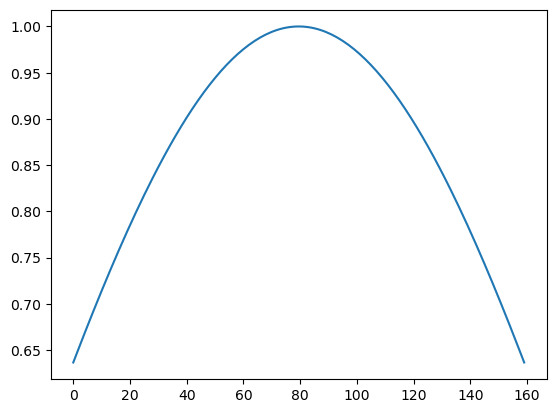

In [18]:
plt.plot(np.sinc(ramlak/2))
plt.plot()
plt.show()

## Reconstrucción FBP V3

reconstrucción FBP


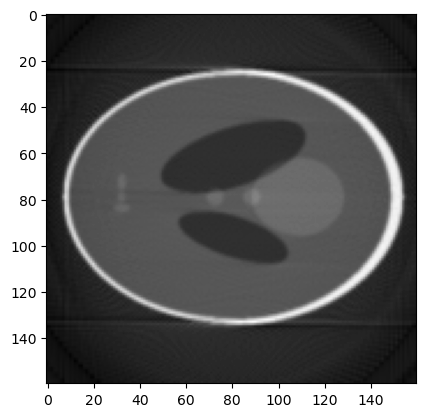

In [19]:
bp = np.zeros((len(sg),len(sg)))
tmp = bp.copy()

sinog = np.swapaxes(sinogram, 0, 1)
fft_R = fftshift(fft(sinog))
filtproj = ifftshift(fft_R * responses['shepp-logan'])
sg = np.real(ifft(filtproj))

sg = np.swapaxes(sg, 0, 1)


for i in range(len(sg[0,:])):
    tmp = np.repeat(sg[:,i], len(bp)).reshape((len(bp), len(bp)))
    tmp = transform.rotate(tmp, angles[i], order=1, clip=True)
    bp = bp + tmp

print('reconstrucción FBP')
plt.figure()
plt.imshow(bp)


In [20]:
len(bp[:,0])

160

## matriz radón

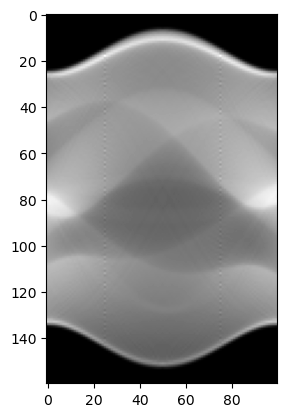

In [53]:
from scipy import sparse

rot_mat = []

pi = np.pi
cos = np.cos
sin = np.sin

angles = np.arange(0, 180, 180/P)
for ang in angles:
    rot_mat.append(np.array([[cos(ang*pi/180), sin(ang*pi/180)], 
                             [-sin(ang*pi/180), cos(ang*pi/180)]], dtype=np.float32))

col_ptr = np.empty(N*N + 1, dtype=np.int32)
q = 0
col_ptr[0] = 0
row_idx = []
vals = []

off = (N//2 - 0.5) if N % 2 == 0 else N//2
X = Y = np.linspace(-off, +off, N)

a = 1

for yi in Y:
    for xi in X:
        for r, rot in enumerate(rot_mat):
            v = (rot @ [xi,yi])

            if v[0] < -off or v[0] > off or v[1] < -off or v[1] > off:
                continue

            x = v[0]+off
            y = off-v[1]
            xint = int(x)
            yint = int(y)
            xm = x - xint
            ym = y - yint

            if xm < 0.001:
                row_idx.append(xint*P + r)
                vals.append(1)
                q += 1
            elif xm > 0.999:
                row_idx.append((xint+1)*P + r)
                vals.append(1)
                q += 1
            else:
                row_idx.extend([xint*P + r, (xint+1)*P + r])
                vals.extend([(1-xm),xm])
                q += 2
        
        col_ptr[a] = q
        a += 1

A = sparse.csc_array((vals, row_idx, col_ptr), shape=(N*P, N*N)) #esta es la matriz, notar que es dispersa (sino no alcanza la memoria)
b = A @ image.flatten() #multiplicar la matriz por la entrada me da el sinograma (b)
plt.figure()
plt.imshow(b.reshape((N,P))) #muestro el sinograma para ver que sea coherente

## reconstrucción GC

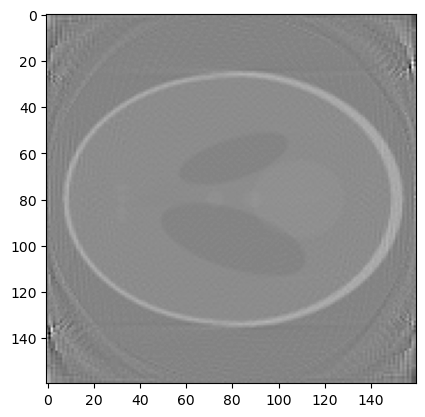

In [42]:
from scipy import optimize

b = sinogram.flatten()
# con la matriz A generada en el paso previo, y con la entrada que es b (sinograma),
# aproximo la inversa de la transformación
# para eso, minimizo el campo f(x) = ||Ax-b||
AT = A.T
ATB =  AT @ b

f = lambda x: (A @ x - b).T @ (A @ x - b)
gradf = lambda x: 2*((AT @ (A @ x)) - ATB)

x0 = np.zeros(N*N, dtype=np.float32)

res = optimize.minimize(f, x0, method='Newton-CG', jac=gradf, options={'maxiter':10})

x = res.x

#print(np.linalg.norm(A @ x - b))
#print(np.linalg.norm(A @ image.flatten() - b))

gc = x.reshape(N, N)

plt.figure()
plt.imshow(gc)